In [ ]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, ops
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import box_iou
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.tensorboard import SummaryWriter

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 1. Data Loading and Preprocessing



In [ ]:
csv_path = "/content/drive/MyDrive/NIH_Chest_Xray/Data_Entry_2017_v2020.csv"
bbox_csv_path = "/content/drive/MyDrive/NIH_Chest_Xray/BBox_List_2017.csv"
bad_labels_csv = "/content/drive/MyDrive/NIH_Chest_Xray/cxr14_bad_labels.csv"
image_dir = "/content/drive/MyDrive/NIH_Chest_Xray/images/good"

# Load datasets
df = pd.read_csv(csv_path)
bbox_df = pd.read_csv(bbox_csv_path)
bad_df = pd.read_csv(bad_labels_csv)

# Clean column names in the bounding box dataframe
bbox_df.columns = [col.strip() for col in bbox_df.columns]
print("Bounding box data columns:", bbox_df.columns)

# Filter out bad labels and "No Finding"
bad_images = bad_df["Index"].tolist()
df = df[~df['Image Index'].isin(bad_images)]
df = df[~df['Finding Labels'].str.contains('No Finding')]

# Build class list
all_labels = df['Finding Labels'].str.split('|').explode().unique().tolist()
classes = sorted(all_labels)
print(f"Classes: {classes}")
print(f"Number of classes: {len(classes)}")

Bounding box data columns: Index(['Image Index;Finding Label;Bbox_x;Bbox_y;Bbox_w;Bbox_h;;;'], dtype='object')
Classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Number of classes: 14


In [ ]:
patient_ids = df["Patient ID"].unique()
train_ids, test_ids = train_test_split(patient_ids, test_size=0.25, random_state=random_seed)
val_ids, test_ids = train_test_split(test_ids, test_size=0.65, random_state=random_seed)

train_df = df[df["Patient ID"].isin(train_ids)]
val_df = df[df["Patient ID"].isin(val_ids)]
test_df = df[df["Patient ID"].isin(test_ids)]

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 39081
Validation set size: 4334
Test set size: 8258


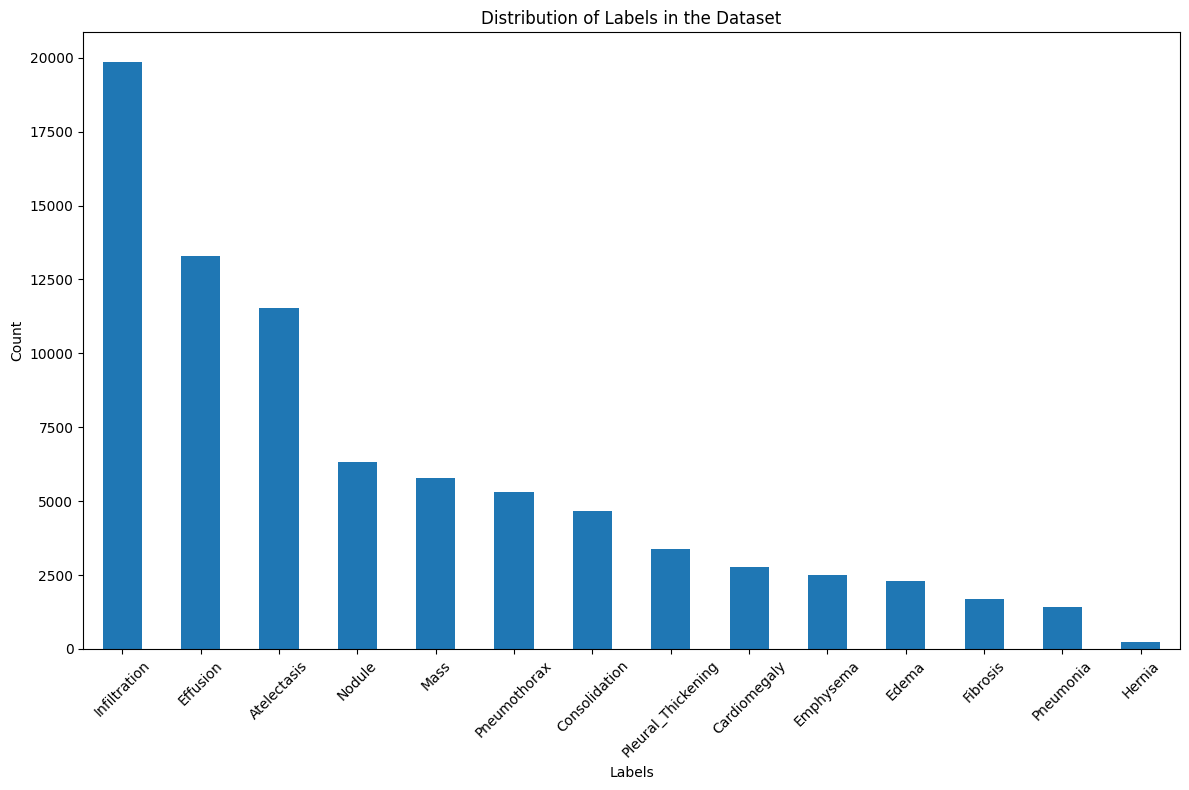

In [ ]:
labels = df['Finding Labels'].str.split('|').explode().value_counts()
plt.figure(figsize=(12, 8))
labels.plot(kind='bar')
plt.title('Distribution of Labels in the Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
bbox_df = bbox_df['Image Index;Finding Label;Bbox_x;Bbox_y;Bbox_w;Bbox_h;;;'].str.split(';', expand=True)
bbox_df.columns = ['Image Index', 'Finding Label', 'Bbox_x', 'Bbox_y', 'Bbox_w', 'Bbox_h', 'col7', 'col8', 'col9']
bbox_df = bbox_df[['Image Index', 'Finding Label', 'Bbox_x', 'Bbox_y', 'Bbox_w', 'Bbox_h']]

print(bbox_df['Finding Label'].value_counts())
bbox_df['Finding Label'] = bbox_df['Finding Label'].replace('Infiltrate', 'Infiltration')

print("Updated Bounding box data with corrected 'Infiltrate' label:")
print(bbox_df[bbox_df['Finding Label'] == 'Infiltration'].head())

Finding Label
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: count, dtype: int64
Updated Bounding box data with corrected 'Infiltrate' label:
          Image Index Finding Label            Bbox_x            Bbox_y  \
460  00020259_002.png  Infiltration  611.555555555556  535.077934027778   
461  00008814_010.png  Infiltration  205.368888888889  392.855711805556   
462  00012021_081.png  Infiltration  655.928888888889  442.917934027778   
463  00005066_030.png  Infiltration  531.911111111111  499.806822916667   
464  00010828_039.png  Infiltration  666.168888888889  450.882378472222   

               Bbox_w            Bbox_h  
460  249.173333333333  199.111111111111  
461  643.982222222222  86.4711111111111  
462  192.284444444444  197.973333333333  
463  242.346666666667            163.84  
464  250.311111111111  246.897777777778  


In [ ]:
bbox_dict = {}
for _, row in bbox_df.iterrows():
    img_name = row['Image Index']
    label = row['Finding Label']
    x, y, w, h = float(row['Bbox_x']), float(row['Bbox_y']), float(row['Bbox_w']), float(row['Bbox_h'])

    if img_name not in bbox_dict:
        bbox_dict[img_name] = []

    bbox_dict[img_name].append({
        'label': label,
        'bbox': [x, y, w, h]  # [x, y, width, height]
    })

print(f"Number of images with bounding boxes: {len(bbox_dict)}")

Number of images with bounding boxes: 880


# 2. Dataset and DataLoader

In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, base_dir, bbox_dict=None, transform=None, mode='both'):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.bbox_dict = bbox_dict if bbox_dict is not None else {}
        self.transform = transform
        self.mode = mode

        self.classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
                'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
                'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

        self.image_locations = {}
        self._locate_all_images()

    def _locate_all_images(self):
        for folder_num in range(1, 13):  # images_001 to images_012
            folder_name = f"images_{folder_num:03d}"
            folder_path = os.path.join(self.base_dir, folder_name, "images")

            if os.path.exists(folder_path):
                for img_name in os.listdir(folder_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_locations[img_name] = os.path.join(folder_path, img_name)
        print(f"Found {len(self.image_locations)} images in the directory structure")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['Image Index']

        img_path = self.image_locations.get(img_name)
        if img_path is None:
            rand_row = self.dataframe.sample(1).iloc[0]
            img_name = rand_row['Image Index']
            img_path = self.image_locations.get(img_name)
            if img_path is None:
                raise FileNotFoundError(f"Cannot locate image for {img_name}")

        image = Image.open(img_path).convert('RGB')
        image_np = np.array(image)

        # classification target
        labels_list = row['Finding Labels'].split('|')
        cls_target = torch.zeros(len(self.classes), dtype=torch.float32)
        for lbl in labels_list:
            if lbl in self.classes:
                cls_target[self.classes.index(lbl)] = 1.0

        # detection targets
        bboxes = []  # list of [x_min, y_min, x_max, y_max]
        det_labels = []
        if img_name in self.bbox_dict:
            for obj in self.bbox_dict[img_name]:
                lbl = obj['label']
                if lbl in self.classes:
                    x, y, w, h = obj['bbox']
                    x1, y1 = x, y
                    x2, y2 = x + w, y + h
                    bboxes.append([x1, y1, x2, y2])
                    det_labels.append(self.classes.index(lbl))

        if self.transform:
            transformed = self.transform(
                image=image_np,
                bboxes=bboxes,
                labels=det_labels
            )
            image = transformed['image']
            bboxes = transformed.get('bboxes', [])
            det_labels = transformed.get('labels', [])
        else:
            image = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0

        if bboxes:
            boxes = torch.tensor(bboxes, dtype=torch.float32)
            labels = torch.tensor(det_labels, dtype=torch.int64)
            det_target = {
                'boxes': boxes,
                'labels': labels + 1,  # add 1 because FasterRCNN expects 1-indexed class labels (0 is background)
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((len(labels),), dtype=torch.int64),
                'has_bbox': True
            }
        else:
            det_target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': torch.zeros((0,), dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64),
                'has_bbox': False
            }

        if self.mode == 'classification':
            return image, cls_target
        elif self.mode == 'detection':
            return image, det_target
        else: # both classification and detection
            return image, cls_target, det_target

    def get_image_info(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['Image Index']

        img_path = self.image_locations.get(img_name)
        if img_path is None:
            img_path = "Image not found"

        return {
            'image_name': img_name,
            'image_path': img_path,
            'finding_labels': row['Finding Labels']
        }

In [ ]:
train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.3),
    A.ColorJitter(brightness=0.1, contrast=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format='pascal_voc',  # [x_min, y_min, x_max, y_max]
    label_fields=['labels'],
    min_visibility=0.2
))

val_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['labels']
))

In [ ]:
def collate_fn(batch):
    if len(batch[0]) == 2:
        if isinstance(batch[0][1], dict):  # detection
            images = []
            targets = []
            for img, t in batch:
                images.append(img)
                targets.append(t)
            return torch.stack(images, 0), targets
        else:  # classification
            return torch.utils.data.dataloader.default_collate(batch)
    else:  # both
        images = []
        cls_targets = []
        det_targets = []
        for img, cls_t, det_t in batch:
            images.append(img)
            cls_targets.append(cls_t)
            det_targets.append(det_t)
        return torch.stack(images, 0), torch.stack(cls_targets, 0), det_targets

In [ ]:
train_dataset = ChestXrayDataset(train_df, image_dir, bbox_dict, train_transform, mode='both')
val_dataset = ChestXrayDataset(val_df, image_dir, bbox_dict, val_transform, mode='both')
test_dataset = ChestXrayDataset(test_df, image_dir, bbox_dict, val_transform, mode='both')

batch_size = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=12,
    collate_fn=collate_fn,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=12,
    collate_fn=collate_fn,
    pin_memory=True
)

Found 112120 images in the directory structure
Found 112120 images in the directory structure
Found 112120 images in the directory structure


# 3. Model Architecture

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes=14, pretrained=True):
        super(MultiTaskModel, self).__init__()
        self.shared_backbone = models.densenet121(pretrained=pretrained).features

        # classification head
        self.cls_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        self.detection_backbone = self.create_detection_backbone()

        # anchor generator for RPN
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )

        # define the RoI pooler
        roi_pooler = ops.MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )


        # create Faster R-CNN detector
        self.detector = FasterRCNN(
            self.detection_backbone,
            num_classes=num_classes + 1,  # +1 for background class
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler,
            min_size=224,
            max_size=224,
            box_score_thresh=0.05,
            box_nms_thresh=0.5
        )

        # freeze the shared backbone parameters for the detector
        for param in self.shared_backbone.parameters():
            param.requires_grad = True

    def create_detection_backbone(self):
        class CustomBackbone(nn.Module):
            def __init__(self, shared_features):
                super(CustomBackbone, self).__init__()
                self.shared_features = shared_features
                self.out_channels = 1024

            def forward(self, x):
                features = self.shared_features(x)
                return {'0': features}

        return CustomBackbone(self.shared_backbone)

    def forward(self, images, targets=None, mode='both'):
        if mode == 'classification' or mode == 'both':
            # classification forward pass
            features = self.shared_backbone(images)
            pooled = self.cls_pool(features)
            cls_output = self.classifier(pooled)

            if mode == 'classification':
                return cls_output

        if mode == 'detection' or mode == 'both':
            # detection forward pass
            if self.training and targets is not None:
                # during training, we need to compute losses
                det_losses = self.detector(images, targets)

                if mode == 'detection':
                    return det_losses

                # for 'both' mode, we return both outputs
                return cls_output, det_losses
            else:
                # during evaluation/inference
                det_output = self.detector(images)

                if mode == 'detection':
                    return det_output

                # for 'both' mode
                return cls_output, det_output

In [ ]:
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    loaded_classes = checkpoint.get('classes', classes)

    model = MultiTaskModel(num_classes=len(loaded_classes), pretrained=False).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model, loaded_classes

def predict_single_image(model, image_path, device, classes):
    transform = val_transform
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)

    transformed = transform(image=image_np)
    input_tensor = transformed['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        cls_output, det_output = model(input_tensor, mode='both')
        cls_probs = torch.sigmoid(cls_output).cpu().numpy()[0]
        det_output = det_output[0]

    cls_results = []
    for i, (cls_name, prob) in enumerate(zip(classes, cls_probs)):
        cls_results.append((cls_name, float(prob)))

    cls_results.sort(key=lambda x: x[1], reverse=True)

    det_results = []
    boxes = det_output['boxes'].cpu().numpy()
    scores = det_output['scores'].cpu().numpy()
    labels = det_output['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score > 0.1:
            det_results.append({
                'class': classes[label-1],
                'score': float(score),
                'box': box.tolist()
            })

    return {
        'classification': cls_results,
        'detection': det_results
    }

# 5. Training Configuration

In [ ]:
model = MultiTaskModel(num_classes=len(classes), pretrained=True).to(device)

cls_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

num_epochs = 15
log_interval = 50
writer = SummaryWriter('runs/multitask_chest_xray')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 156MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  wa

In [ ]:
def train_epoch(model, train_loader, optimizer, epoch, device):
    model.train()
    cls_losses = []
    rpn_losses = []
    roi_losses = []
    total_losses = []

    batch_count = len(train_loader)
    start_time = time.time()

    for batch_idx, (images, cls_targets, det_targets) in enumerate(train_loader):
        images = images.to(device)
        cls_targets = cls_targets.to(device)

        # filter out images without bounding boxes for detection training
        valid_det_targets = []
        valid_det_idxs = []

        for i, target in enumerate(det_targets):
            if target['has_bbox']:
                target = {k: v.to(device) if isinstance(v, torch.Tensor) else v
                         for k, v in target.items()}
                valid_det_targets.append(target)
                valid_det_idxs.append(i)

        optimizer.zero_grad()

        if valid_det_targets:
            valid_images = images[valid_det_idxs]
            valid_cls_targets = cls_targets[valid_det_idxs]

            # forward pass for images with bounding boxes
            cls_output, det_losses = model(valid_images, valid_det_targets, mode='both')

            # calculate classification loss
            cls_loss = cls_criterion(cls_output, valid_cls_targets)

            # extract detection losses
            rpn_loss = det_losses['loss_objectness'] + det_losses['loss_rpn_box_reg']
            roi_loss = det_losses['loss_classifier'] + det_losses['loss_box_reg']

            # total loss
            total_loss = cls_loss + rpn_loss + roi_loss

            total_loss.backward()

            # logging
            cls_losses.append(cls_loss.item())
            rpn_losses.append(rpn_loss.item())
            roi_losses.append(roi_loss.item())
            total_losses.append(total_loss.item())

        # handle images without bounding boxes
        non_det_idxs = [i for i in range(len(images)) if i not in valid_det_idxs]
        if non_det_idxs:
            non_det_images = images[non_det_idxs]
            non_det_cls_targets = cls_targets[non_det_idxs]

            cls_output = model(non_det_images, mode='classification')

            cls_loss = cls_criterion(cls_output, non_det_cls_targets)

            cls_loss.backward()

            cls_losses.append(cls_loss.item())

        optimizer.step()

        # logging
        if (batch_idx + 1) % log_interval == 0 or (batch_idx + 1) == batch_count:
            elapsed = time.time() - start_time
            print(f'Epoch {epoch+1}/{num_epochs} [{batch_idx+1}/{batch_count} ({100. * (batch_idx+1) / batch_count:.0f}%)]'
                  f' - Time: {elapsed:.1f}s - Cls Loss: {np.mean(cls_losses):.4f}' +
                  (f' - RPN Loss: {np.mean(rpn_losses):.4f} - ROI Loss: {np.mean(roi_losses):.4f}'
                   if rpn_losses else ''))

            # log to TensorBoard
            global_step = epoch * batch_count + batch_idx
            writer.add_scalar('train/classification_loss', np.mean(cls_losses), global_step)
            if rpn_losses:
                writer.add_scalar('train/rpn_loss', np.mean(rpn_losses), global_step)
                writer.add_scalar('train/roi_loss', np.mean(roi_losses), global_step)
                writer.add_scalar('train/total_loss', np.mean(total_losses), global_step)

    # return average losses for the epoch
    avg_cls_loss = np.mean(cls_losses)
    avg_rpn_loss = np.mean(rpn_losses) if rpn_losses else 0
    avg_roi_loss = np.mean(roi_losses) if roi_losses else 0
    avg_total_loss = np.mean(total_losses) if total_losses else avg_cls_loss

    return {
        'classification_loss': avg_cls_loss,
        'rpn_loss': avg_rpn_loss,
        'roi_loss': avg_roi_loss,
        'total_loss': avg_total_loss
    }

In [ ]:
def validate(model, val_loader, device, epoch=None, classes=None):
    model.eval()
    cls_losses = []
    all_cls_targets = []
    all_cls_preds = []

    all_det_targets = []
    all_det_preds = []

    with torch.no_grad():
        for images, cls_targets, det_targets in val_loader:
            images = images.to(device)
            cls_targets = cls_targets.to(device)

            cls_output, det_output = model(images, mode='both')

            # classification loss
            cls_loss = cls_criterion(cls_output, cls_targets)
            cls_losses.append(cls_loss.item())

            # store predictions and targets for metrics calculation
            all_cls_targets.append(cls_targets.cpu().numpy())
            all_cls_preds.append(torch.sigmoid(cls_output).cpu().numpy())

            # store detection predictions and targets
            for i, (target, pred) in enumerate(zip(det_targets, det_output)):
                if target['has_bbox']:
                    gt_boxes = target['boxes'].cpu().numpy()
                    gt_labels = target['labels'].cpu().numpy()

                    pred_boxes = pred['boxes'].cpu().numpy()
                    pred_scores = pred['scores'].cpu().numpy()
                    pred_labels = pred['labels'].cpu().numpy()

                    all_det_targets.append((gt_boxes, gt_labels))
                    all_det_preds.append((pred_boxes, pred_scores, pred_labels))

    all_cls_targets = np.vstack(all_cls_targets)
    all_cls_preds = np.vstack(all_cls_preds)

    # AUC per class
    aucs = []
    for i in range(all_cls_targets.shape[1]):
        if np.sum(all_cls_targets[:, i]) > 0:
            auc = roc_auc_score(all_cls_targets[:, i], all_cls_preds[:, i])
            aucs.append(auc)
        else:
            aucs.append(float('nan'))

    mean_auc = np.nanmean(aucs)

    #
    aps = []
    for i in range(all_cls_targets.shape[1]):
        if np.sum(all_cls_targets[:, i]) > 0:
            ap = average_precision_score(all_cls_targets[:, i], all_cls_preds[:, i])
            aps.append(ap)
        else:
            aps.append(float('nan'))

    mean_ap_cls = np.nanmean(aps)

    # mAP
    detection_aps = calculate_detection_map(all_det_targets, all_det_preds)
    mean_ap_det = np.nanmean(list(detection_aps.values()))

    if epoch is not None:
        writer.add_scalar('val/classification_loss', np.mean(cls_losses), epoch)
        writer.add_scalar('val/mean_auc', mean_auc, epoch)
        writer.add_scalar('val/mean_ap_cls', mean_ap_cls, epoch)
        writer.add_scalar('val/mean_ap_det', mean_ap_det, epoch)

        if classes:
            for i, class_name in enumerate(classes):
                writer.add_scalar(f'val/auc/{class_name}', aucs[i], epoch)
                writer.add_scalar(f'val/ap_cls/{class_name}', aps[i], epoch)
                if i+1 in detection_aps:
                    writer.add_scalar(f'val/ap_det/{class_name}', detection_aps[i+1], epoch)

    metrics = {
        'classification_loss': np.mean(cls_losses),
        'mean_auc': mean_auc,
        'mean_ap_cls': mean_ap_cls,
        'mean_ap_det': mean_ap_det,
        'aucs': aucs,
        'aps_cls': aps,
        'aps_det': detection_aps
    }

    return metrics

In [ ]:
def calculate_detection_map(all_targets, all_preds, iou_threshold=0.5):
    all_detections = {}
    all_ground_truths = {}

    for i in range(1, 15):
        all_detections[i] = []
        all_ground_truths[i] = []

    for (gt_boxes, gt_labels), (pred_boxes, pred_scores, pred_labels) in zip(all_targets, all_preds):
        for box, label in zip(gt_boxes, gt_labels):
            all_ground_truths[label].append(box)

        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            all_detections[label].append((box, score))

    # AP per class
    aps = {}
    for cls_id in range(1, 15):
        if not all_ground_truths[cls_id]:
            continue

        dets = all_detections[cls_id]
        if not dets:
            aps[cls_id] = 0.0
            continue

        dets.sort(key=lambda x: x[1], reverse=True)
        boxes = np.array([d[0] for d in dets])
        scores = np.array([d[1] for d in dets])

        gt_boxes = np.array(all_ground_truths[cls_id])

        if len(gt_boxes) == 0:
            aps[cls_id] = 0.0
            continue

        tp = np.zeros(len(boxes))
        fp = np.zeros(len(boxes))
        used_gt = np.zeros(len(gt_boxes))

        for i, box in enumerate(boxes):
            if len(gt_boxes) == 0:
                fp[i] = 1
                continue

            # IoU
            ious = []
            for gt_box in gt_boxes:
                box_tensor = torch.tensor([box], dtype=torch.float32)
                gt_box_tensor = torch.tensor([gt_box], dtype=torch.float32)
                iou = box_iou(box_tensor, gt_box_tensor).item()
                ious.append(iou)

            max_iou_idx = np.argmax(ious)
            max_iou = ious[max_iou_idx]

            if max_iou >= iou_threshold and not used_gt[max_iou_idx]:
                tp[i] = 1
                used_gt[max_iou_idx] = 1
            else:
                fp[i] = 1

        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)
        rec = tp_cum / len(gt_boxes)
        prec = tp_cum / (tp_cum + fp_cum)

        ap = 0
        for t in np.arange(0, 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap += p / 11

        aps[cls_id] = ap

    return aps

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs, device, classes):
    best_val_loss = float('inf')
    best_model_path = 'best_model.pth'

    history = {
        'train_cls_loss': [],
        'train_total_loss': [],
        'val_cls_loss': [],
        'val_mean_auc': [],
        'val_mean_ap_cls': [],
        'val_mean_ap_det': []
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 40)

        train_losses = train_epoch(model, train_loader, optimizer, epoch, device)

        val_metrics = validate(model, val_loader, device, epoch, classes)

        lr_scheduler.step(val_metrics['classification_loss'])

        history['train_cls_loss'].append(train_losses['classification_loss'])
        history['train_total_loss'].append(train_losses['total_loss'])
        history['val_cls_loss'].append(val_metrics['classification_loss'])
        history['val_mean_auc'].append(val_metrics['mean_auc'])
        history['val_mean_ap_cls'].append(val_metrics['mean_ap_cls'])
        history['val_mean_ap_det'].append(val_metrics['mean_ap_det'])

        print(f"Validation - Cls Loss: {val_metrics['classification_loss']:.4f}, " +
              f"Mean AUC: {val_metrics['mean_auc']:.4f}, " +
              f"Cls mAP: {val_metrics['mean_ap_cls']:.4f}, " +
              f"Det mAP: {val_metrics['mean_ap_det']:.4f}")

        if val_metrics['classification_loss'] < best_val_loss:
            best_val_loss = val_metrics['classification_loss']
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_metrics': val_metrics,
            }, best_model_path)
            print(f"Saved best model at epoch {epoch+1}")

    return history, model

# 6. Model Training

In [ ]:
history, trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    num_epochs=15,
    device=device,
    classes=classes
)


Epoch 1/15
----------------------------------------
Epoch 1/15 [50/2443 (2%)] - Time: 268.3s - Cls Loss: 0.4693 - RPN Loss: 0.3577 - ROI Loss: 0.4453
Epoch 1/15 [100/2443 (4%)] - Time: 287.5s - Cls Loss: 0.4090 - RPN Loss: 0.1826 - ROI Loss: 0.2489
Epoch 1/15 [150/2443 (6%)] - Time: 306.4s - Cls Loss: 0.3797 - RPN Loss: 0.1289 - ROI Loss: 0.2175
Epoch 1/15 [200/2443 (8%)] - Time: 324.4s - Cls Loss: 0.3639 - RPN Loss: 0.1113 - ROI Loss: 0.1994
Epoch 1/15 [250/2443 (10%)] - Time: 345.2s - Cls Loss: 0.3560 - RPN Loss: 0.0962 - ROI Loss: 0.1739
Epoch 1/15 [300/2443 (12%)] - Time: 365.1s - Cls Loss: 0.3509 - RPN Loss: 0.0858 - ROI Loss: 0.1582
Epoch 1/15 [350/2443 (14%)] - Time: 384.1s - Cls Loss: 0.3464 - RPN Loss: 0.0794 - ROI Loss: 0.1474
Epoch 1/15 [400/2443 (16%)] - Time: 405.9s - Cls Loss: 0.3436 - RPN Loss: 0.0736 - ROI Loss: 0.1392
Epoch 1/15 [450/2443 (18%)] - Time: 423.9s - Cls Loss: 0.3387 - RPN Loss: 0.0699 - ROI Loss: 0.1344
Epoch 1/15 [500/2443 (20%)] - Time: 446.7s - Cls Los

<ipython-input-18-1493724942>:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  box_tensor = torch.tensor([box], dtype=torch.float32)


Validation - Cls Loss: 0.2807, Mean AUC: 0.7436, Cls mAP: 0.2701, Det mAP: 0.0592
Saved best model at epoch 1

Epoch 2/15
----------------------------------------
Epoch 2/15 [50/2443 (2%)] - Time: 12.2s - Cls Loss: 0.3040 - RPN Loss: 0.0345 - ROI Loss: 0.0996
Epoch 2/15 [100/2443 (4%)] - Time: 19.0s - Cls Loss: 0.2957 - RPN Loss: 0.0336 - ROI Loss: 0.0822
Epoch 2/15 [150/2443 (6%)] - Time: 26.3s - Cls Loss: 0.2942 - RPN Loss: 0.0293 - ROI Loss: 0.0771
Epoch 2/15 [200/2443 (8%)] - Time: 33.6s - Cls Loss: 0.2928 - RPN Loss: 0.0294 - ROI Loss: 0.0748
Epoch 2/15 [250/2443 (10%)] - Time: 40.6s - Cls Loss: 0.2918 - RPN Loss: 0.0299 - ROI Loss: 0.0718
Epoch 2/15 [300/2443 (12%)] - Time: 47.2s - Cls Loss: 0.2902 - RPN Loss: 0.0291 - ROI Loss: 0.0701
Epoch 2/15 [350/2443 (14%)] - Time: 53.8s - Cls Loss: 0.2884 - RPN Loss: 0.0292 - ROI Loss: 0.0691
Epoch 2/15 [400/2443 (16%)] - Time: 61.0s - Cls Loss: 0.2866 - RPN Loss: 0.0292 - ROI Loss: 0.0662
Epoch 2/15 [450/2443 (18%)] - Time: 71.7s - Cls Lo

# 7. Evaluation & Plotting

In [ ]:
def plot_training_curves(history):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    # plot classification loss
    axs[0, 0].plot(history['train_cls_loss'], 'o-', label='Train Classification Loss')
    axs[0, 0].plot(history['val_cls_loss'], 's-', label='Validation Classification Loss')
    axs[0, 0].set_title('Classification Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # plot total loss
    axs[0, 1].plot(history['train_total_loss'], 'o-', label='Train Total Loss')
    axs[0, 1].set_title('Total Loss (Classification + Detection)')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    # plot AUC
    axs[1, 0].plot(history['val_mean_auc'], 's-', label='Validation Mean AUC')
    axs[1, 0].set_title('Validation Mean AUC')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('AUC')
    axs[1, 0].legend()

    # plot mAP
    axs[1, 1].plot(history['val_mean_ap_cls'], 's-', label='Validation Classification mAP')
    axs[1, 1].plot(history['val_mean_ap_det'], 's--', label='Validation Detection mAP')
    axs[1, 1].set_title('Validation Mean Average Precision')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('mAP')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

In [ ]:
def visualize_predictions(model, dataset, idx, device, classes):
    model.eval()

    img_info = dataset.get_image_info(idx)
    print(f"Image: {img_info['image_name']}")
    print(f"Labels: {img_info['finding_labels']}")

    image, cls_target, det_target = dataset[idx]

    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(device)
        cls_output, det_output = model(input_tensor, mode='both')
        cls_probs = torch.sigmoid(cls_output).cpu().numpy()[0]
        det_output = det_output[0]

    img_path = img_info['image_path']
    orig_img = np.array(Image.open(img_path).convert('RGB'))

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    axs[0].imshow(orig_img)
    axs[0].set_title('Ground Truth')

    if det_target['has_bbox']:
        boxes = det_target['boxes'].cpu().numpy()
        labels = det_target['labels'].cpu().numpy()

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, edgecolor='green', linewidth=2)
            axs[0].add_patch(rect)
            axs[0].text(x1, y1-10, classes[label-1],
                      color='green', fontsize=12,
                      bbox=dict(facecolor='white', alpha=0.7))

    axs[1].imshow(orig_img)
    axs[1].set_title('Predictions')

    boxes = det_output['boxes'].cpu().numpy()
    scores = det_output['scores'].cpu().numpy()
    labels = det_output['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score > 0.6:
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, edgecolor='red', linewidth=2)
            axs[1].add_patch(rect)
            axs[1].text(x1, y1-10, f"{classes[label-1]}: {score:.2f}",
                      color='red', fontsize=12,
                      bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.savefig(f'prediction_{idx}.png')
    plt.show()

    print("\nClassification Results:")
    results = []
    for i, (cls_name, target, prob) in enumerate(zip(classes, cls_target, cls_probs)):
        results.append((cls_name, float(target), float(prob)))

    results.sort(key=lambda x: x[2], reverse=True)

    for cls_name, target, prob in results:
        print(f"{cls_name}: GT={target:.0f}, Pred={prob:.4f}")


In [ ]:
def evaluate_model(model, test_loader, device, classes):
    model.eval()
    metrics = validate(model, test_loader, device, classes=classes)

    print("\n===== Test Set Evaluation =====")
    print(f"Classification Loss: {metrics['classification_loss']:.4f}")
    print(f"Mean AUC: {metrics['mean_auc']:.4f}")
    print(f"Classification mAP: {metrics['mean_ap_cls']:.4f}")
    print(f"Detection mAP: {metrics['mean_ap_det']:.4f}")

    print("\nPer-Class Metrics:")
    print("-" * 60)
    print(f"{'Class':20} {'AUC':10} {'Cls AP':10} {'Det AP':10}")
    print("-" * 60)

    for i, cls_name in enumerate(classes):
        auc = metrics['aucs'][i]
        ap_cls = metrics['aps_cls'][i]
        ap_det = metrics['aps_det'].get(i+1, float('nan'))

        print(f"{cls_name:20} {auc:.4f}     {ap_cls:.4f}     {ap_det:.4f}")

    return metrics

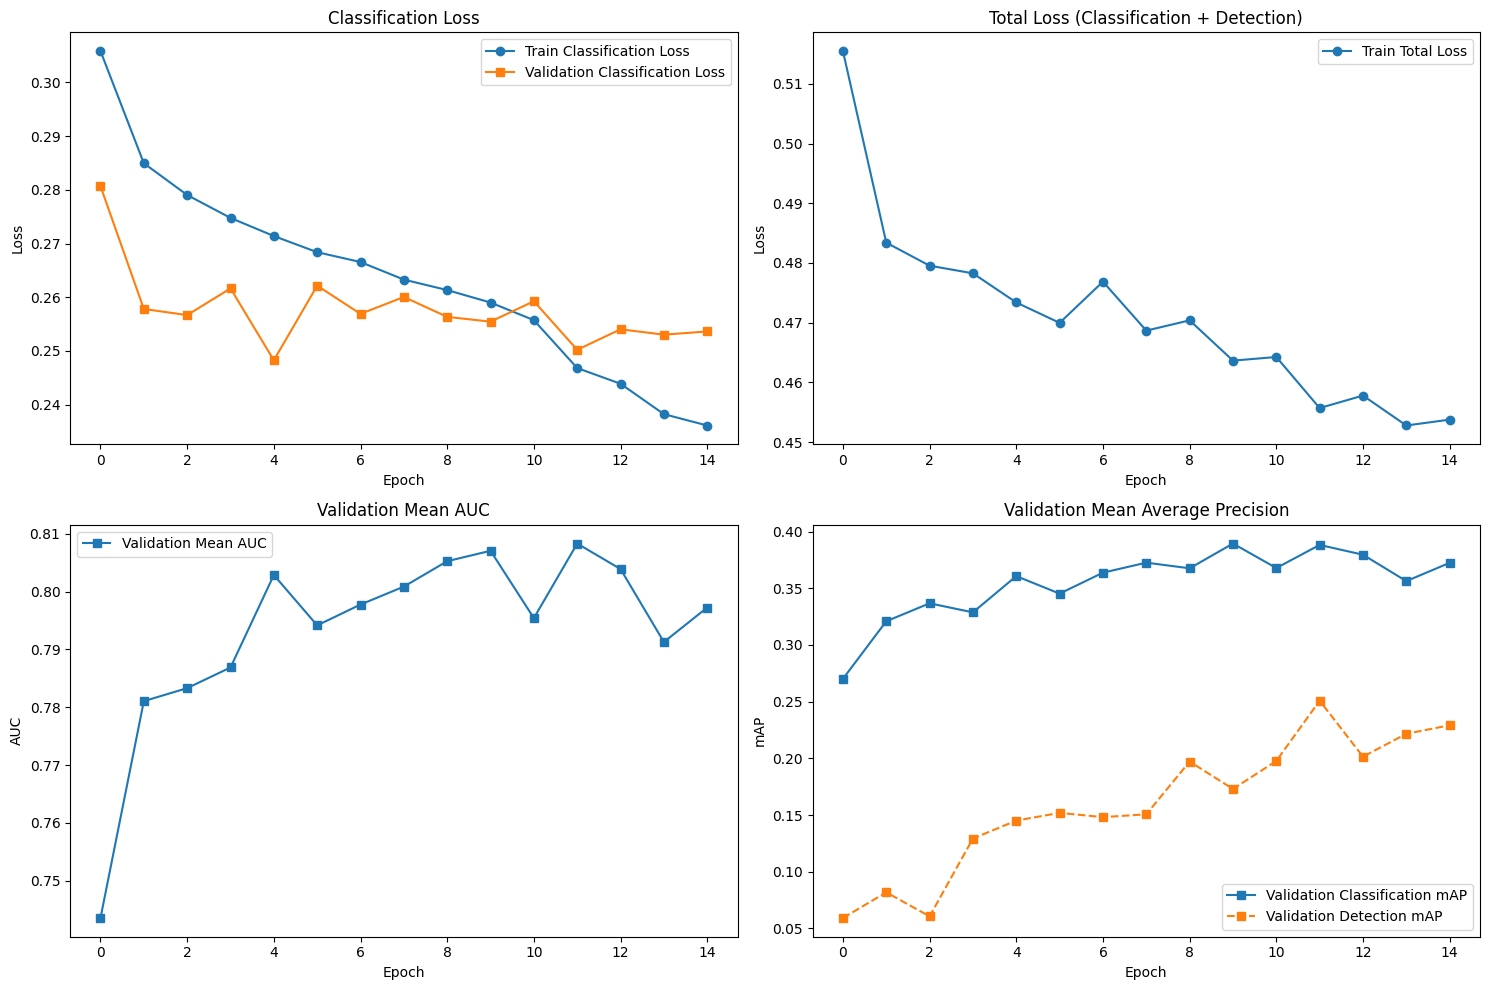

Image: 00000023_004.png
Labels: Infiltration|Mass|Nodule


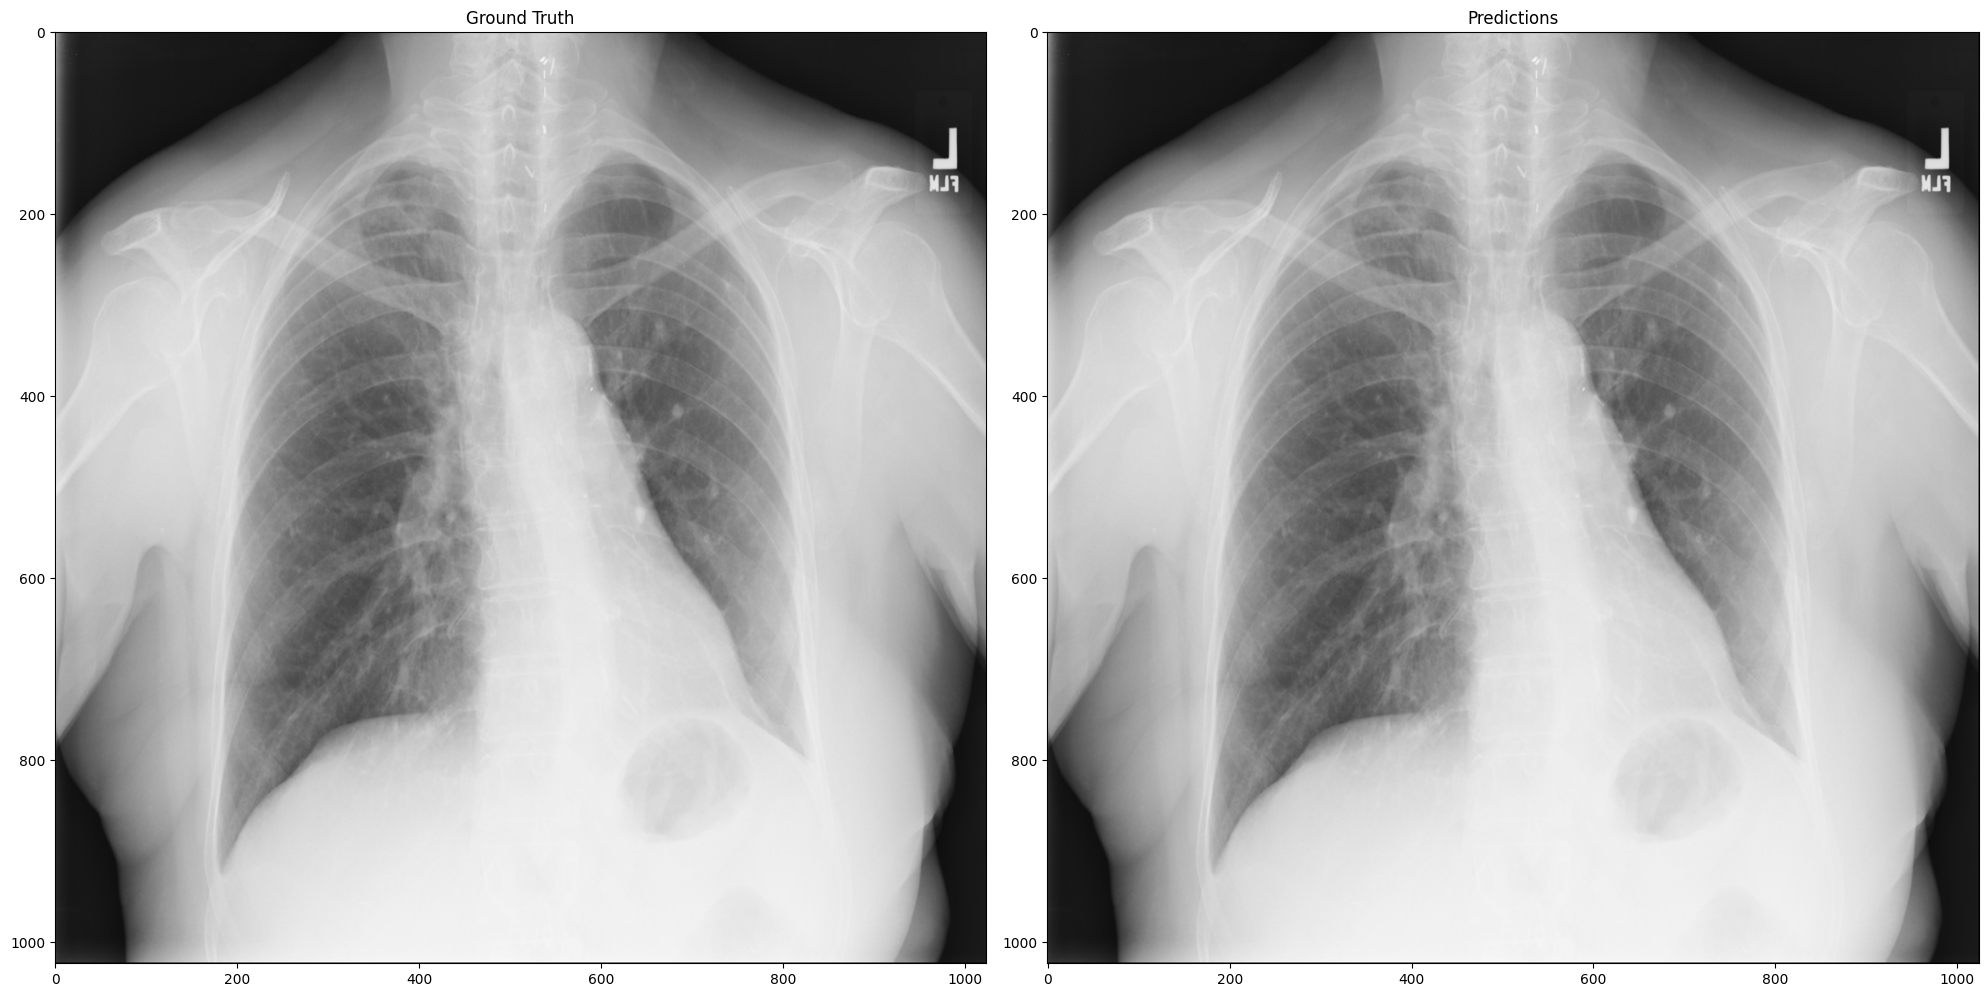


Classification Results:
Nodule: GT=1, Pred=0.6310
Effusion: GT=0, Pred=0.1258
Pleural_Thickening: GT=0, Pred=0.0770
Mass: GT=1, Pred=0.0558
Fibrosis: GT=0, Pred=0.0525
Atelectasis: GT=0, Pred=0.0502
Infiltration: GT=1, Pred=0.0497
Consolidation: GT=0, Pred=0.0310
Emphysema: GT=0, Pred=0.0268
Pneumothorax: GT=0, Pred=0.0084
Pneumonia: GT=0, Pred=0.0026
Cardiomegaly: GT=0, Pred=0.0006
Edema: GT=0, Pred=0.0001
Hernia: GT=0, Pred=0.0001
Image: 00000061_009.png
Labels: Effusion|Infiltration


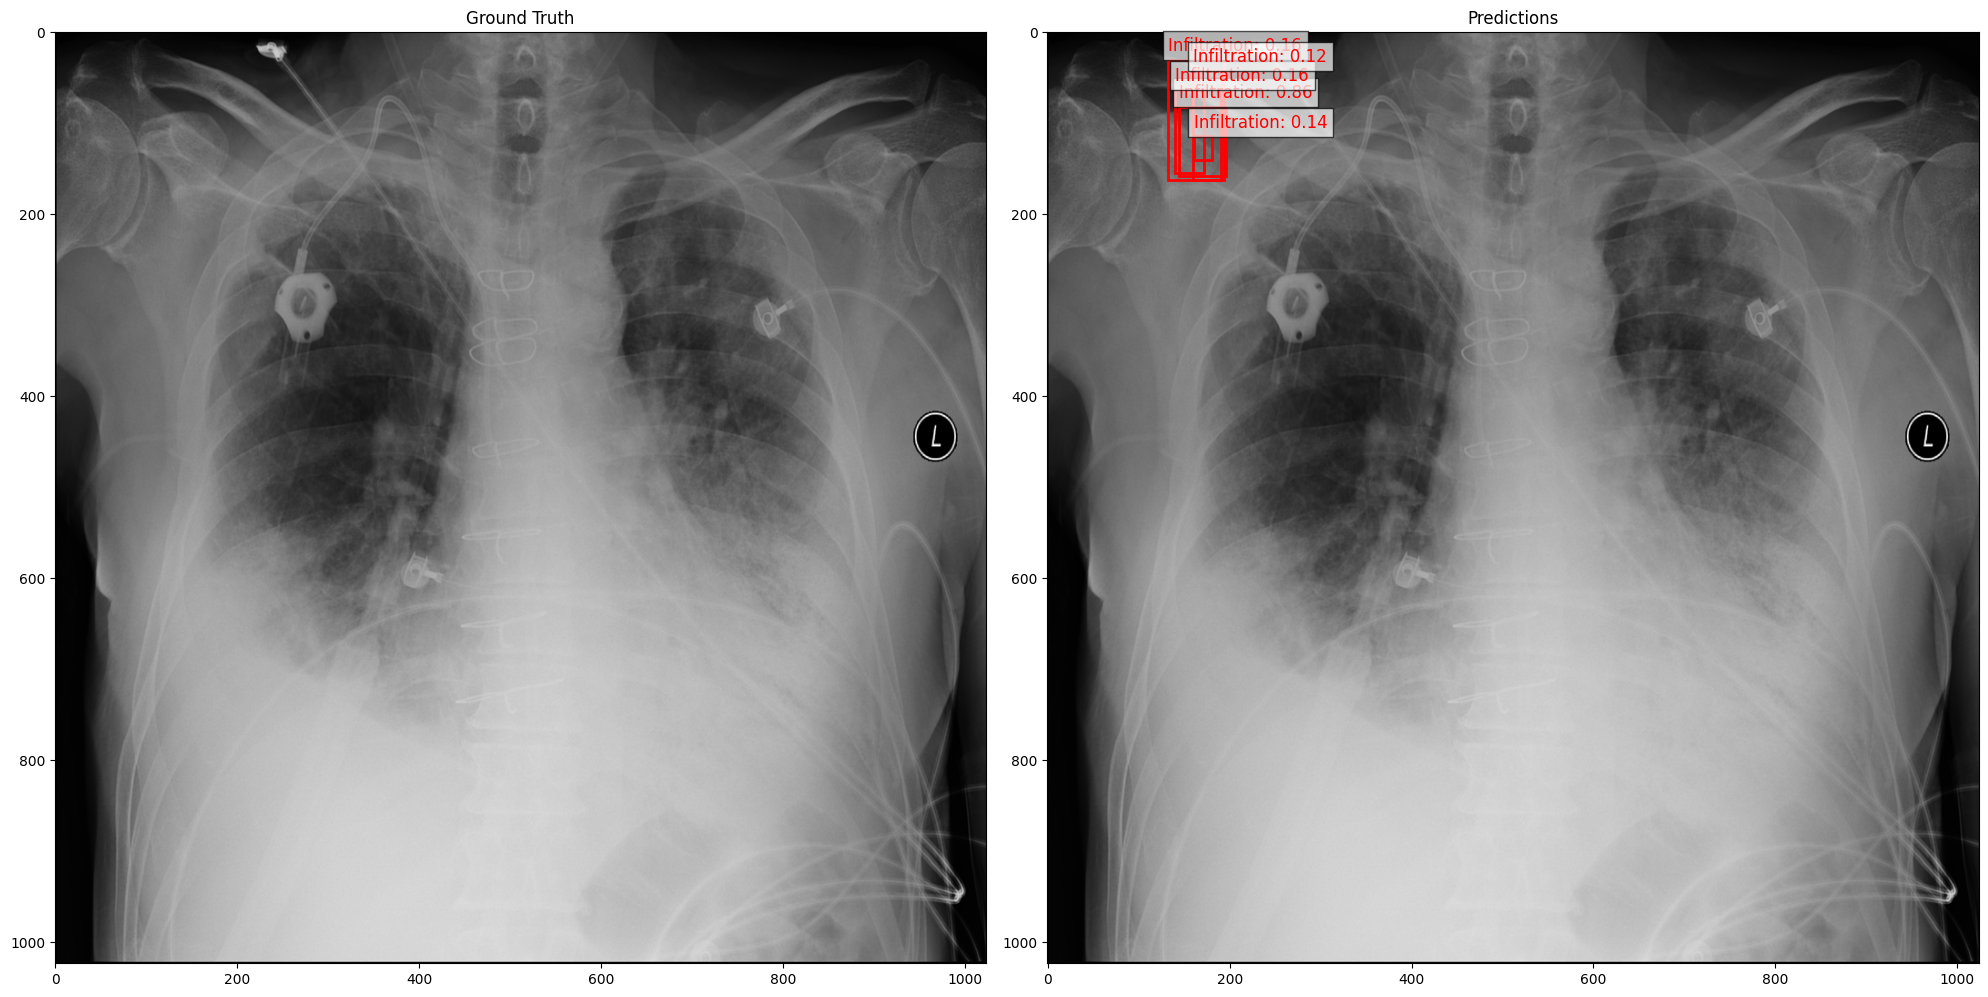


Classification Results:
Effusion: GT=1, Pred=0.7407
Infiltration: GT=1, Pred=0.5224
Mass: GT=0, Pred=0.1975
Consolidation: GT=0, Pred=0.1488
Nodule: GT=0, Pred=0.1480
Atelectasis: GT=0, Pred=0.0738
Pleural_Thickening: GT=0, Pred=0.0616
Edema: GT=0, Pred=0.0382
Pneumothorax: GT=0, Pred=0.0199
Pneumonia: GT=0, Pred=0.0130
Cardiomegaly: GT=0, Pred=0.0008
Fibrosis: GT=0, Pred=0.0008
Emphysema: GT=0, Pred=0.0007
Hernia: GT=0, Pred=0.0000
Image: 00000149_005.png
Labels: Atelectasis


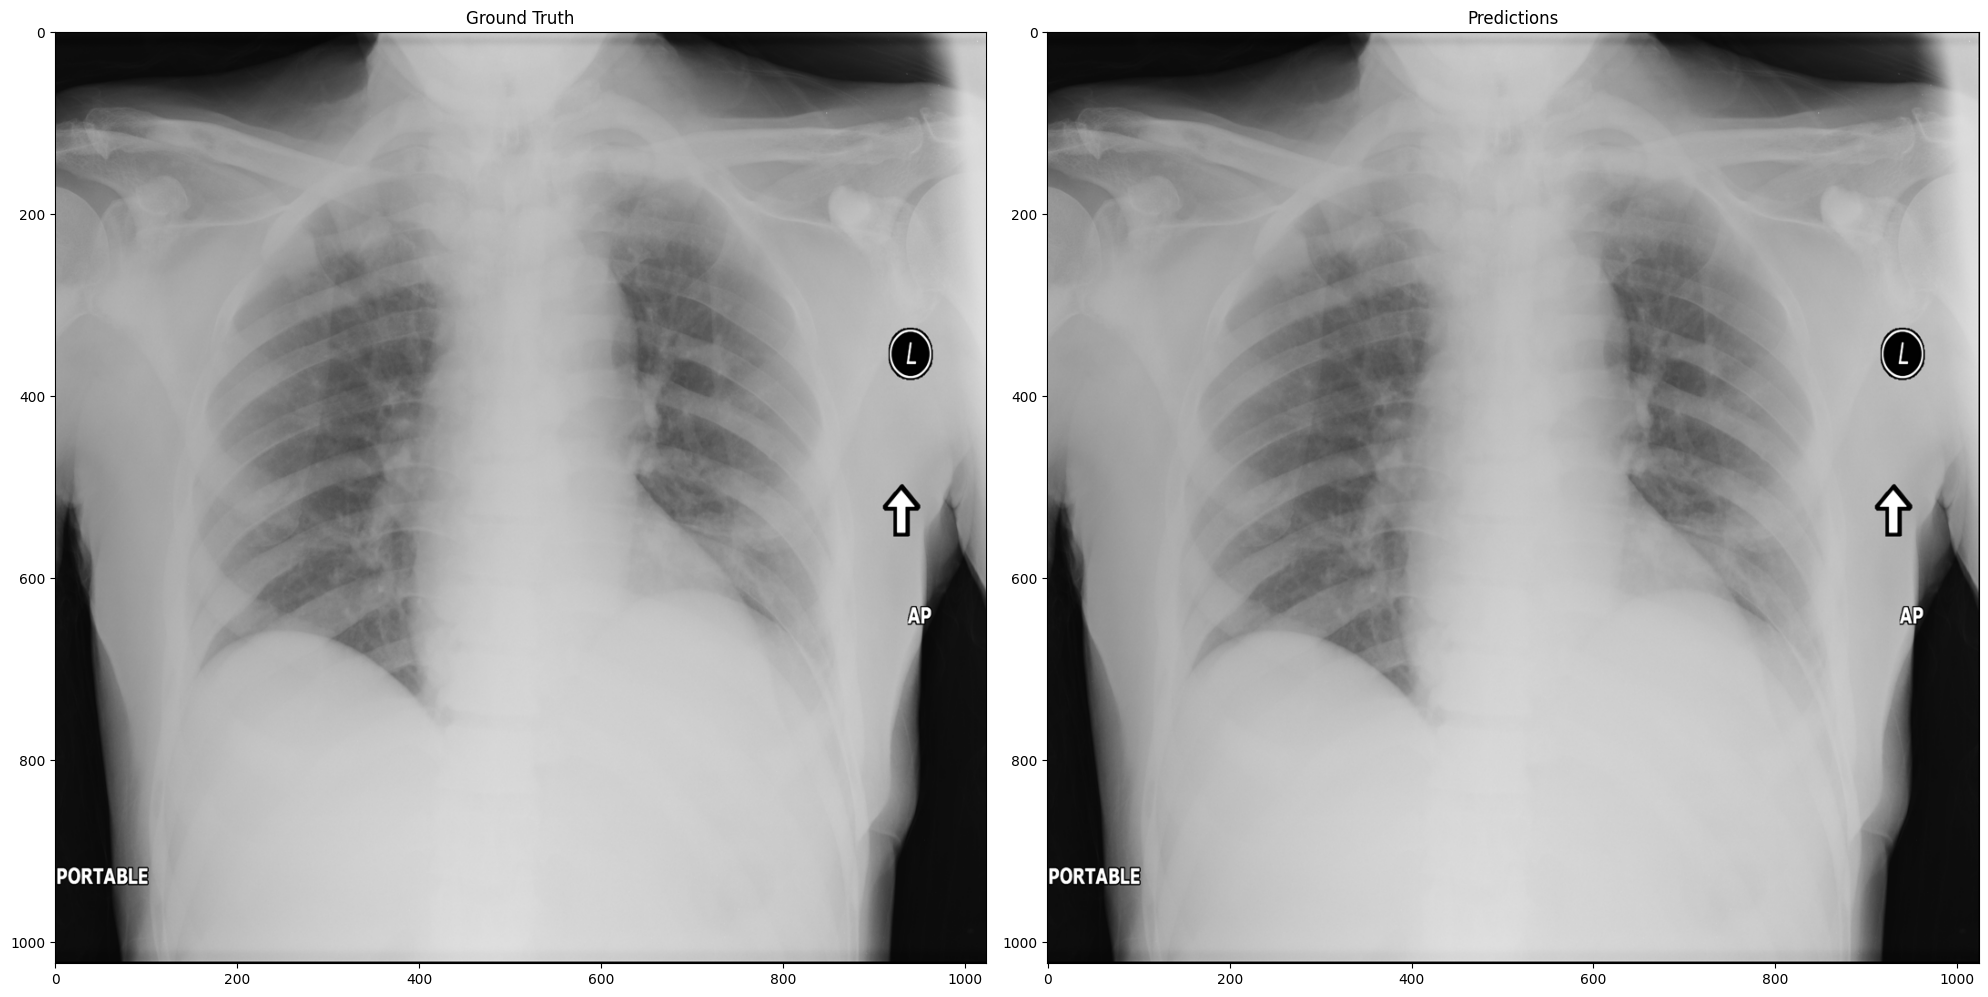


Classification Results:
Effusion: GT=0, Pred=0.6511
Atelectasis: GT=1, Pred=0.2898
Infiltration: GT=0, Pred=0.0547
Nodule: GT=0, Pred=0.0538
Consolidation: GT=0, Pred=0.0178
Mass: GT=0, Pred=0.0117
Fibrosis: GT=0, Pred=0.0109
Emphysema: GT=0, Pred=0.0102
Pleural_Thickening: GT=0, Pred=0.0068
Pneumothorax: GT=0, Pred=0.0038
Pneumonia: GT=0, Pred=0.0010
Edema: GT=0, Pred=0.0009
Cardiomegaly: GT=0, Pred=0.0002
Hernia: GT=0, Pred=0.0000

===== Test Set Evaluation =====
Classification Loss: 0.2722
Mean AUC: 0.7893
Classification mAP: 0.3691
Detection mAP: 0.2137

Per-Class Metrics:
------------------------------------------------------------
Class                AUC        Cls AP     Det AP    
------------------------------------------------------------
Atelectasis          0.7779     0.5263     0.1374
Cardiomegaly         0.8705     0.4206     0.4233
Consolidation        0.6703     0.1617     nan
Edema                0.8543     0.2333     nan
Effusion             0.8187     0.6165     0.

In [ ]:
plot_training_curves(history)

for idx in [5, 20, 50]:
    visualize_predictions(model, test_dataset, idx, device, classes)

test_metrics = evaluate_model(model, test_loader, device, classes)

# 8. Save Final Model

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'classes': classes,
    'test_metrics': test_metrics,
}, 'final_multitask_model.pth')

print("\nModel saved to 'final_multitask_model.pth'")